In [1]:
using DataFrames, GraphPlot, Impute, Plots, Colors, Distributions

dir = "../../Mariana-Paquete/Mariana-Basefunc/"

include(dir*"funciones_de_red.jl")
include(dir*"objetos.jl")
include(dir*"dinamica_conductores.jl")
include(dir*"animaciones.jl")

plot_digraph (generic function with 1 method)

In [2]:
"""
    simulacion!(tiempo_universal, red, autos)
Given the network `red` and an array of drivers `autos`, generates the complete simulation until all drivers reach their destination,
the simulation goes in discrete steps of time, each one representing an action. Possible actions are:
- A car leaves its origin.
- A car changes edge.
- A car reaches its destination. 
"""
function simulacion!(tiempo_universal::Float64, Red::network, Autos::Array{auto,1})
    time_array = []
    ocupaciones = []
    m = size(Red.city_matrix,1)
    vel_matrix = zeros(m,m)

    # Mientras haya autos que no hayan llegado a su destino
    while (length([auto for auto in Autos if auto.llego!=0.]) < length(Autos))
        # Se calculan el siguiente cambio de arista y el siguiente tiempo de salida
        sts, car_sale = sig_ts(tiempo_universal, Red, Autos)
        sca, car_cambia = sig_ca(Red, Autos)
        siguiente_tiempo = min(sts, sca)

        # si lo que sigue es una salida de destino
        if sts < sca 
            # el tiempo universal se adelanta por siguiente_tiempo
            tiempo_universal += siguiente_tiempo
            push!(time_array, tiempo_universal)
            push!(ocupaciones, Red.city_matrix[:,:,3])

            # se cambia el estado del auto que sale a is_out = true
            car_sale.is_out = true
            u = car_sale.o
            v = dst(car_sale.astarpath[1])
            # se aumenta en 1 al numero de autos de la arista de la que salió
            Red.city_matrix[u,v,3] += 1.

        # si lo que sigue es un cambio de arista
        elseif sca <= sts && (sca != Inf)
            # el tiempo universal se adelanta por siguiente_tiempo
            tiempo_universal += siguiente_tiempo
            push!(time_array, tiempo_universal)
            push!(ocupaciones, Red.city_matrix[:,:,3])

            u = car_cambia.last_node
            car_cambia.speed_memory[u] = car_cambia.vel
            index1 = findall(x->src(x)==u, car_cambia.astarpath)    
            v = dst(car_cambia.astarpath[index1][1])
            # se resta un auto del número de autos de la arista que deja
            Red.city_matrix[u,v,3] -= 1.
            # se actualiza el último nodo por el que pasó el auto
            car_cambia.last_node = v
            # si con esta acción el auto llega a destino se registra el tiempo en el que llegó
            if v == car_cambia.d
                car_cambia.llego = tiempo_universal
                save_position(car_cambia,Red,Red.position_array[car_cambia.d])
            # si no ha llegado y cambia de arista se amenta el uno el número de autos a la arista a la que va
            else
                index2 = findall(x->src(x)==v, car_cambia.astarpath)    
                w = dst(car_cambia.astarpath[index2][1])
                car_cambia.next_node = w
                Red.city_matrix[v,w,3] += 1.      
            end
        else
            print("Red atascada","\n")
            print("con ", sum(Red.city_matrix[:,:,3]), " autos en ruta","\n")
            
            return time_array, vel_matrix/(length(time_array)), ocupaciones
            break
        end
        push!(ocupaciones,Red.city_matrix[:,:,3])
        # para todos los autos que están en ruta
        for auto in [auto for auto in Autos if (auto.is_out && auto.llego==0.)]
            # el avance de los autos es su velocidad por el pedazo de tiempo que avanza la simulación
            auto.avance += auto.vel * siguiente_tiempo
            # excepto para el auto que cambió, o para autos que no pueden cambiar de arista
            # a ellos les pondremos otros avances.

            if (sca<=sts && auto==car_cambia)
                # al auto que cambió le ponemos 0
                auto.avance = 0.0
            end

            longitud = norm(Red.position_array[auto.last_node]-Red.position_array[auto.next_node])
            if (auto.avance-longitud >= 0.0)
                # a los autos que no pueden avanzar les ponemos a que avancen hasta la esquina pero no más alla
                auto.avance == (longitud)*(0.9 + 0.9*rand())
            end
            
            u = auto.last_node
            v = auto.next_node
            save_position(auto,Red,
            Red.position_array[u]+auto.avance*(Red.position_array[v]-Red.position_array[u])/norm(Red.position_array[v]-Red.position_array[u]))
        end

        for auto in [auto for auto in Autos if !(auto.is_out)]
            save_position(auto,Red,[NaN,NaN])
        end
        dist_matrix = distance_matrix(Red.position_array)
        
        # por último se actualizan los tiempos de recorrido en la red
        Red.city_matrix[:,:,4] = BPR.(Red.city_matrix[:,:,1], Red.city_matrix[:,:,3],Red.city_matrix[:,:,2]);
        vel_matrix += dist_matrix./Red.city_matrix[:,:,4];
    end
    #print("\n tiempo final"*string(tiempo_universal))
    return time_array, vel_matrix/(length(time_array)), ocupaciones
end


simulacion!

In [3]:
# Parametros
tamano_red = 5;
doble_sentido = false;
center_h_dist = 0.5;
sd_h_dist = 0;
h_distribution = Normal(center_h_dist, sd_h_dist);
n_cars = 1500;
ti = 0.0;
tf = 150.0;
max_n_dias = 10;
diag_start = [7.,160.];
pendiente = -pi/5;

In [4]:
red_cuadrada = make_churubusco(tamano_red, diag_start, pendiente, both_ways=doble_sentido);
SqNet= red_cuadrada.digraph;
m = nv(SqNet);
posarr = red_cuadrada.position_array;
city_mt = red_cuadrada.city_matrix;

In [5]:
fig, cols = plot_digraph(SqNet, posarr, separated_edges=true);

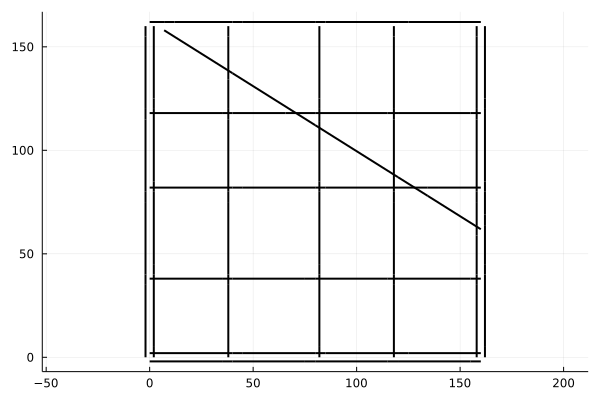

In [6]:
fig

In [8]:
capacidad_total = 0.
for edge in edges(SqNet)
    u = src(edge)
    v = dst(edge)
    capacidad_total += city_mt[u,v,2]
end
capacidad_total

442.0

In [9]:
autos = generate_autos(m,tamano_red,red_cuadrada,n_cars,ti,tf,h_distribution);

In [10]:
times, vels, ocupacion = simulacion!(0.,red_cuadrada, autos);

Red atascada
con 340.0 autos en ruta


In [11]:
fig, cols = plot_digraph(SqNet,posarr, attribute_matrix=vels,separated_edges=true,
c1 = colorant"red", c2 = colorant"green",
min_value = 0., max_value = 15.0);

In [12]:
cols

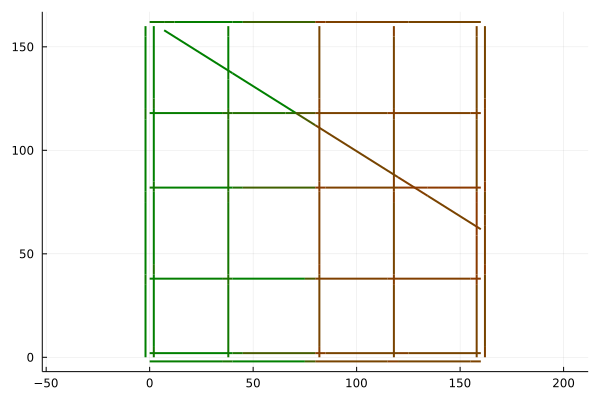

In [13]:
fig

In [14]:
saturaciones = [ocup./city_mt[:,:,2] for ocup in ocupacion];

In [15]:
fig, cols = plot_digraph(SqNet,posarr, attribute_matrix=last(saturaciones),separated_edges=true,
c1 = colorant"green", c2 = colorant"red",
min_value = 0., max_value = 1.0);

In [16]:
cols

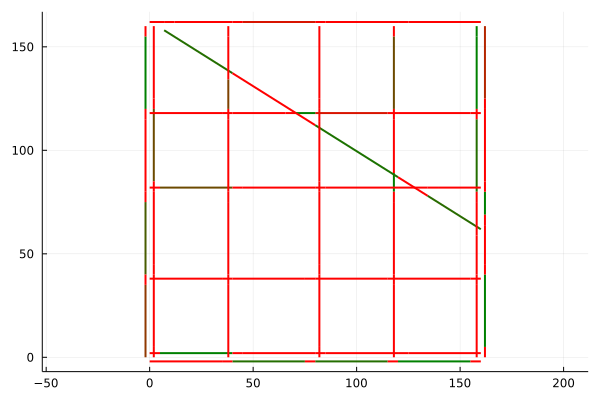

In [17]:
fig

In [18]:
cropped_times = round.(times, digits=1);

In [24]:
last(cropped_times)*2

299.4

In [25]:
indexes = []
for i in 1:299
    if length(findall(x -> x == i*0.5, cropped_times)) > 0
        index = findall(x -> x == i*0.5, cropped_times)[1]
        push!(indexes, index)
    end
end

In [26]:
reduced_times = [cropped_times[x] for x in indexes];
reduced_saturaciones = [saturaciones[x] for x in indexes];

In [27]:
length(reduced_times)

180

┌ Info: Saved animation to 
│   fn = /Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/gifs-saturacion/test-churubusco.gif
└ @ Plots /Users/Mariana/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/gifs-saturacion/test-churubusco.gif")
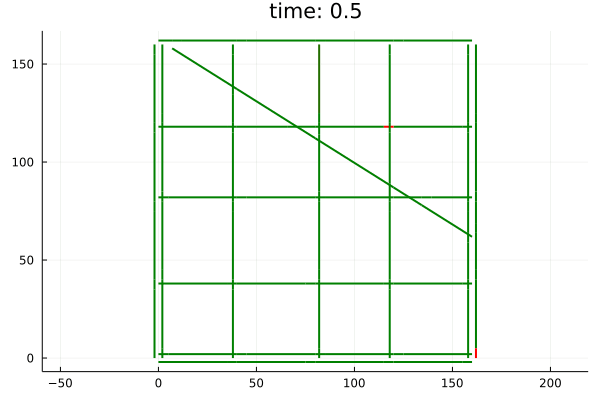

In [22]:
anim = @animate for i in 1:length(reduced_times)
    fig, cols = plot_digraph(SqNet, posarr,attribute_matrix=reduced_saturaciones[i],
    separated_edges=true,
    c1 = colorant"green", c2 = colorant"red",
    min_value = 0., max_value = 1.0)
    time = reduced_times[i]
    fig
    plot!(title="time: $time")
end
gif(anim, "test-churubusco.gif", fps = 5)